In [2]:
import mne
import pandas as pd
import numpy as np

# Read data from "derivatives/sub-xp101/eeg_pp/sub-xp101_task-motorloc_eeg_pp.vhdr"
data_raw=mne.io.read_raw_brainvision('C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/sub-xp101/eeg/sub-xp101_task-motorloc_eeg.vhdr')


Extracting parameters from C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/sub-xp101/eeg/sub-xp101_task-motorloc_eeg.vhdr...
Setting channel info structure...


In [3]:
data=mne.io.read_raw_brainvision('C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/derivatives/sub-xp101/eeg_pp/sub-xp101_task-motorloc_eeg_pp.vhdr')

Extracting parameters from C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/derivatives/sub-xp101/eeg_pp/sub-xp101_task-motorloc_eeg_pp.vhdr...
Setting channel info structure...


C:\Users\Alex\AppData\Local\Temp\ipykernel_10236\1752249042.py:1: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  data=mne.io.read_raw_brainvision('C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/derivatives/sub-xp101/eeg_pp/sub-xp101_task-motorloc_eeg_pp.vhdr')
C:\Users\Alex\AppData\Local\Temp\ipykernel_10236\1752249042.py:1: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['ECG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  data=mne.io.read_raw_brainvision('C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/derivatives/sub-xp101/eeg_pp/sub-xp101_task-motorloc_eeg_pp.vhdr')


In [4]:
%matplotlib tk

In [6]:
data_raw.plot()

Opening raw-browser...


In [5]:
data.plot()

Using qt as 2D backend.
Opening raw-browser...


In [7]:
data_filt=data.copy().load_data().filter(0.3,60)

Reading 0 ... 67387  =      0.000 ...   336.935 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 2201 samples (11.005 sec)



In [8]:

data_filt.plot()

Opening raw-browser...


In [ ]:
data.ch_names #names of the channels of the EEG

In [4]:
# Another way to extract the events, not used

#events=pd.read_table('C:/Users/ernes/Desktop/Master/Course 21-22/2nd term 21-22/Neuroimage/Week 6/task-motorloc_events.tsv')
#dummies=pd.get_dummies(events,columns=['trial_type']).drop(columns=['duration','trial_type_Rest'])
#dummies['onset']=dummies['onset']*200
#events=dummies.to_numpy()

In [10]:
events=mne.events_from_annotations(data_filt) #extract the events from the data
events 

Used Annotations descriptions: ['New Segment/', 'Pulse Artifact/R', 'Response/R128', 'Stimulus/S  1', 'Stimulus/S 99', 'TPULSE/TEND', 'TPULSE/TPEAK', 'TPULSE/TSTART']


(array([[    0,     0, 99999],
        [ 2230,     0,  1128],
        [ 2249,     0, 10001],
        ...,
        [67030,     0,  1128],
        [67075,     0, 10001],
        [67227,     0, 10001]]),
 {'New Segment/': 99999,
  'Pulse Artifact/R': 10001,
  'Response/R128': 1128,
  'Stimulus/S  1': 1,
  'Stimulus/S 99': 99,
  'TPULSE/TEND': 10002,
  'TPULSE/TPEAK': 10003,
  'TPULSE/TSTART': 10004})

In [11]:
#select events in the task blocks
blockstart=False
new_events=np.zeros([1,3],dtype=np.int16)
for i in range(len(events[0])):
    if events[0][i,2] == 1:
        blockstart=True
        j=1
    while blockstart and i+j<558:
        if events[0][i+j,2]==10001:
            curr_event=events[0][i+j]
            new_events=np.concatenate((new_events,np.expand_dims(curr_event,axis=0)),axis=0)
            
        if events[0][i+j,2]==99:
            blockstart=False
        j=j+1
new_events=new_events[1:]

In [15]:
#Create a new channel called stimulation (STI) needed to add the events
stim=mne.create_info(['STI'],200,['stim'])
stim_raw=mne.io.RawArray(np.zeros([1,67388]),stim)
data_filt.load_data().add_channels([stim_raw],force_update_info=True)

Creating RawArray with float64 data, n_channels=1, n_times=67388
    Range : 0 ... 67387 =      0.000 ...   336.935 secs
Ready.


<RawBrainVision | sub-xp101_task-motorloc_eeg_pp.dat, 65 x 67388 (336.9 s), ~33.5 MB, data loaded>

In [ ]:
data_filt.ch_names #see the STI channel at the end

In [16]:
data_filt.add_events(events[0],stim_channel='STI',replace=True) #add the events to the data

In [17]:
event_id = 1 #take the value of the 'Stimulus/S 10001': 10001
tmin = 3  # start of each epoch (200ms before the trigger)
tmax = 17  # end of each epoch (500ms after the trigger) 
baseline = (None, None) 

In [29]:
reject_criteria = dict(eeg=600e-5)      
picks = mne.pick_types(data_filt.info, meg=False, eeg=True, stim=False, misc=True,
                       include=[])

In [30]:
epochs = mne.Epochs(data_filt, events[0], event_id, tmin, tmax, picks=picks, proj=False,
                    baseline=baseline, reject=reject_criteria)

In [35]:
#matplotlib tk
czepochs=epochs.copy().load_data().pick_channels(['Cz'])
czepochs.plot()

In [34]:
epochs.plot()

In [39]:
epochs.plot_image(picks=['Pz'])

[<Figure size 640x480 with 4 Axes>]

In [36]:
evoked = epochs.average() #mean of the epochs to get the evoked response
evoked.plot(time_unit='s') #plot of the evoked response
evoked.plot_topomap(times=np.linspace(3, 17, 30), ch_type='eeg',time_unit='s') #topomap

C:\Users\Alex\anaconda3\envs\mne\lib\site-packages\mne\channels\layout.py:268: RuntimeWarning: invalid value encountered in true_divide
  loc2d /= scale
C:\Users\Alex\AppData\Local\Temp\ipykernel_10236\2325629461.py:3: RuntimeWarning: More than 25 topomaps plots requested. This might take a while.
  evoked.plot_topomap(times=np.linspace(3, 17, 30), ch_type='eeg',time_unit='s') #topomap


RuntimeError: No position information found, cannot compute geometries for topomap.

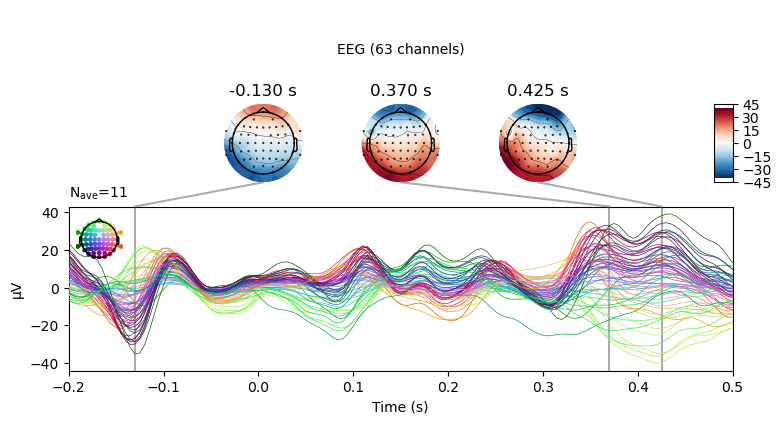

In [37]:
mne.viz.plot_evoked_joint(evoked)